# *Training a model to predict the location of bounding boxes and type of asphalt distress in the UAPD Dataset*
This model will use a VGG16 backbone and a classification head as well as a bounding box regression head. It requests a GPU from colab (if available) 

# Mount Drive and Import packages

In [1]:
from google.colab import drive
import os
drive.mount('/content/drive')
CurrentDir='/content/drive/My Drive/Pavement/ICTD/WorkshopCNN' #path of project
os.chdir(CurrentDir)

Mounted at /content/drive


In [2]:
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.utils import plot_model
from keras import backend as K

# Load the saved dataset
Loading the npy files and then encoding the labels, dividing the bounding boxes to normalize between 0 and 1, and splitting into train and test

In [4]:
IMG_H=512
IMG_W=IMG_H
Num_Class=3
# Load the saved data
image_data = np.load('data/npdata/image_data.npy') 

bounding_boxes = np.load('data/npdata/bounding_boxes.npy') / IMG_H
labels = np.load('data/npdata/labels.npy')

# Perform one-hot encoding on the labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
one_hot_labels = to_categorical(encoded_labels, num_classes=Num_Class)
train_labels = to_categorical(encoded_labels, Num_Class)
print(np.unique(labels,return_counts=True))
# Split the data into training and testing sets
train_images, test_images, train_labels, test_labels, train_bboxes, test_bboxes = train_test_split(
    image_data, one_hot_labels, bounding_boxes, test_size=0.2, random_state=42)


(array(['Crack', 'Pothole', 'Repair'], dtype='<U7'), array([1994,   44, 1104]))


# Defining a model 
VGG16 back bone and two heads. One for classification, one for bounding box

In [ ]:
# Load the VGG16 model as the base model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_H, IMG_W, 3))
base_model.trainable = False

# Classification head
classification_head = models.Sequential(name="classification_head")
classification_head.add(layers.Flatten())
classification_head.add(layers.Dense(512, activation='relu'))
classification_head.add(layers.Dense(512, activation='relu'))
classification_head.add(layers.Dense(Num_Class, activation='softmax'))

# Bounding box regression head
bbox_head = models.Sequential(name="bbox_head")
bbox_head.add(layers.Conv2D(128, (2, 2), activation='relu'))  # Convolutional layer
bbox_head.add(layers.BatchNormalization())  # BatchNormalization layer
bbox_head.add(layers.Flatten())
bbox_head.add(layers.Dense(64, activation='relu'))
bbox_head.add(layers.Dense(4, activation='sigmoid'))  # 4 values for (xmin, ymin, xmax, ymax)


# Connect the heads to the base model
classification_output = classification_head(base_model.output)
bbox_output = bbox_head(base_model.output)

# Create the complete model
model = models.Model(inputs=base_model.input, outputs=[classification_output, bbox_output])

plot_model(model, to_file='model.png')

Compile the model

In [6]:
# Compile the model with appropriate loss functions
lossWeights = {
    "classification_head": 1.0,
    "bbox_head": 1.0
}
model.compile(optimizer='adam',
              loss={'classification_head': 'categorical_crossentropy', 'bbox_head':'mse'},
              metrics={'classification_head': 'accuracy'}, loss_weights=lossWeights)

num_epochs = 500

model_path = os.path.join("model/", "model7.h5") #4,5,6 are good at classification not at bounding box
csv_path = os.path.join("model/", "log7.csv")

callbacks = [ModelCheckpoint(model_path, verbose=1, save_best_only=True),
             ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
             CSVLogger(csv_path, append=True),
             EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False)]


Train the model

In [7]:
history = model.fit(train_images, {"classification_head": train_labels, "bbox_head": train_bboxes},
                    epochs=num_epochs, validation_split=0.1, callbacks=callbacks)

Epoch 1/500
71/71 [==============================] - ETA: 0s - loss: 11.0799 - classification_head_loss: 10.9167 - bbox_head_loss: 0.1632 - classification_head_accuracy: 0.7063
Epoch 1: val_loss improved from inf to 1.44566, saving model to model/model7.h5
71/71 [==============================] - 198s 2s/step - loss: 11.0799 - classification_head_loss: 10.9167 - bbox_head_loss: 0.1632 - classification_head_accuracy: 0.7063 - val_loss: 1.4457 - val_classification_head_loss: 1.3051 - val_bbox_head_loss: 0.1406 - val_classification_head_accuracy: 0.7579 - lr: 0.0010
Epoch 2/500
71/71 [==============================] - ETA: 0s - loss: 0.6621 - classification_head_loss: 0.5655 - bbox_head_loss: 0.0967 - classification_head_accuracy: 0.8992
Epoch 2: val_loss improved from 1.44566 to 1.25788, saving model to model/model7.h5
71/71 [==============================] - 174s 2s/step - loss: 0.6621 - classification_head_loss: 0.5655 - bbox_head_loss: 0.0967 - classification_head_accuracy: 0.8992 - v

KeyboardInterrupt: ignored

# Inference
Make predictions over some test images

1/1 [==============================] - 9s 9s/step


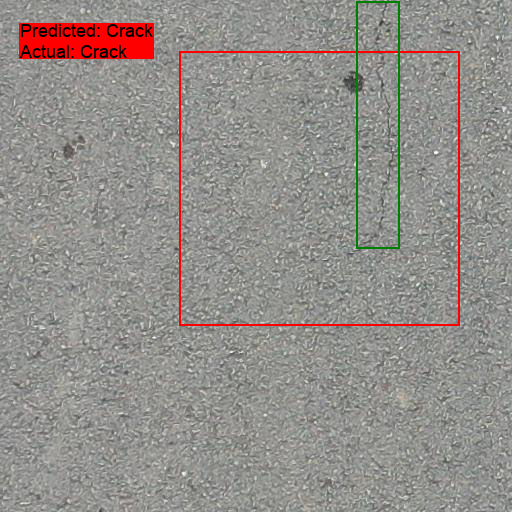

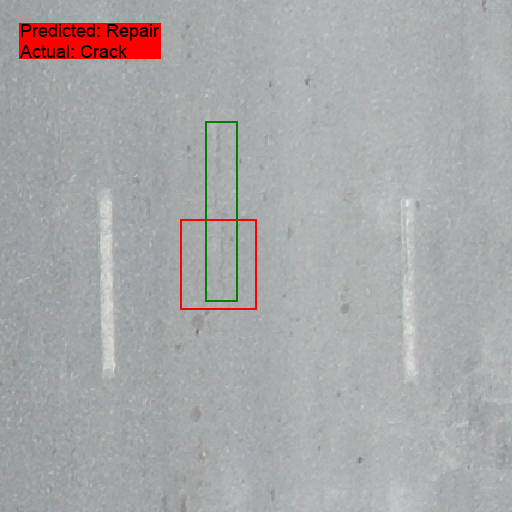

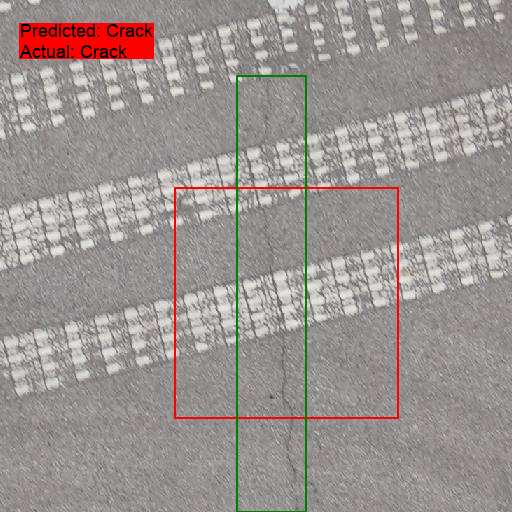

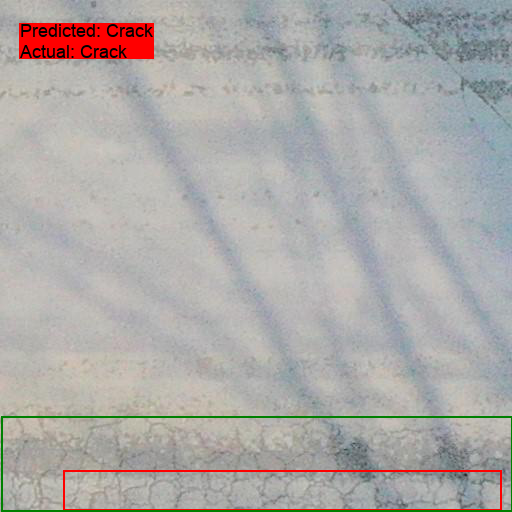

In [6]:
import numpy as np
from PIL import Image, ImageDraw, ImageFont
from tensorflow import keras
model_path = os.path.join("model/", "finalmodel.h5")
#model = keras.models.load_model(model_path)
# Select four example images from the dataset
indices = [0,1,2,5,8,12,16]  # Choose the indices of the images you want to predict 5
indices = [4,6,9,12]  # Choose the indices of the images you want to predict 4,6,9,12
image_data_examples = image_data[indices]
label_examples = labels[indices]
bbox_examples = bounding_boxes[indices]

image_data_examples = test_images[indices]
label_examples = test_labels[indices]
bbox_examples = test_bboxes[indices]
# Reshape the image data to match the expected input shape of the model
image_data_examples = np.reshape(image_data_examples, (len(indices), 512, 512, 3))

# Make predictions on the images
class_predictions, bbox_predictions = model.predict(image_data_examples)

# Get the predicted labels
predicted_label_indices = np.argmax(class_predictions, axis=1)
true_label_indices=np.argmax(label_examples, axis=1)
predicted_labels = label_encoder.inverse_transform(predicted_label_indices)
true_labels = label_encoder.inverse_transform(true_label_indices)

# Get the predicted bounding boxes
predicted_boxes = bbox_predictions

# Loop over the examples and display the images with predicted vs actual labels
for i in range(len(indices)):
    image_example = Image.fromarray(image_data_examples[i].astype(np.uint8))
    true_label = true_labels[i]
    true_bbox = bbox_examples[i]
    predicted_label = predicted_labels[i]
    predicted_bbox = predicted_boxes[i]
    text = f"Predicted: {predicted_label}\nActual: {true_label}"
    
    # Draw the labels on the image
    font = ImageFont.truetype("arial.ttf", 18)
    draw = ImageDraw.Draw(image_example)
    bbox = draw.textbbox((20, 20), text, font=font)
    draw.rectangle(bbox, fill="red")
    draw.text((20, 20), text, font=font, fill="black")

    # Draw the predicted bounding box on the image
    xmin_pred, ymin_pred, xmax_pred, ymax_pred = predicted_bbox*512
    draw.rectangle([(xmin_pred, ymin_pred), (xmax_pred, ymax_pred)], outline="red", width=2)

    # Draw the actual bounding box on the image
    xmin_true, ymin_true, xmax_true, ymax_true = true_bbox*512
    draw.rectangle([(xmin_true, ymin_true), (xmax_true, ymax_true)], outline="green", width=2)

    # Display the image
    image_example.show()
